# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [3]:
# Imports here
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from collections import OrderedDict
import json

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# DONE: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
                                      

valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = valid_transforms

# DONE: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform = test_transforms)
test_data = datasets.ImageFolder(test_dir, transform = valid_transforms)

# DONE: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [27]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
#### print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [7]:
# build the constructor we will use to construct our model
# using ReLU activations and dropout
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [8]:
def check_on_dataset(model, testloader, criterion, device = 'cuda'):
    ''' Measures accuracy of model's predictions on given data 
        
            Arguments
            ---------
            model: trained (/ being trained) model used to make prediction. /!\ Already on right device
            testloader : dataset to apply model on, containing labels and images
            /!\ data must be correctly formatted w/ appropriate transforms
            criterion: the loss function used
            device: device to be used
            
            Returns; tuple (loss, accuracy)
            ---------
            loss: flat, loss of model on given dataset
            accuracy: float, % of right predictions on given dataset
        '''
    model.eval() # put the model on eval mode
    model.to(device)
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            test_loss += criterion(output, labels).item()
            predicted = torch.max(output.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return test_loss / len(testloader), (100 * correct) / total

In [9]:
def do_deep_learning(model, trainloader, epochs, criterion, optimizer, device = 'cuda', print_every = 38):
    ''' Defines a function to train a model
        
            Arguments
            ---------
            model: model to train
            trainloader: data loader containing train data
            epochs: int, number of epochs
            criterion: loss function used
            optimizer: optimizer used
            device: device to use to run computations
            print_every: int, frequency to get stats on model performance
            
            Side effects
            ---------
            Alongside training, prints, at a (print-every) frequency:
            - the test accuracy: network's accuracy, measured on the test data
            - the validation loss
            - the validation accuracy
            
        '''
    steps = 0
    model.to(device)
    running_loss = 0
    # just to make sure the model is on training mode
    model.train()
    # for each epoch...
    for e in range(epochs):
        # for each batch of images in the train data...
        for inputs, labels in trainloader:
            print('Step: {}.. '.format(steps))
            torch.cuda.empty_cache()
            inputs, labels = inputs.to(device), labels.to(device)
            steps += 1
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Track loss and accuracy on validation test 
            if steps % print_every == 0:
                model.eval() # put the model on eval mode
                # turn off the gradients to save memory and computation
                with torch.no_grad():
                    valid_loss, valid_accuracy = check_on_dataset(model, validloader, criterion, device)
                print("Epochs: {}/{}.. ".format(e + 1, epochs),
                      "Training loss: {:.3f}.. ".format(running_loss / print_every), 
                      "Valid loss: {:.3f}.. ".format(valid_loss),
                      "Valid accuracy: {:.3f} %.. ".format(valid_accuracy))
                running_loss = 0
                model.train() # put model back on training

In [10]:
# GIVE ALL HYPER-PARAMETERS

# load pretrained model
model = models.vgg16(pretrained = True)

# freeze the model's parameters
for param in model.parameters():
    param.required_grad = False

# Define a new, untrained feed-forward network as a classifier
# using ReLU activations and dropout
input_size = 25088
hidden_layers = [1000, 500]
output_size = 102
dropout_p = 0.3
classifier = Network(input_size, output_size, hidden_layers, dropout_p)

# replace the model's classifier w/ ours
model.classifier = classifier

epochs = 3
criterion = nn.NLLLoss() # since used log-softmax, use NLLLoss as criterion
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:22<00:00, 24268485.05it/s]


In [11]:
# DONE: Build and train your network
# Train the classifier layers using the pre-trained network to get the features
# commented out not to run unvoluntarily
### do_deep_learning(model, trainloader, epochs, criterion, optimizer, device)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# DONE: Do validation on the test set
model.eval() # put the model on eval mode
with torch.no_grad():
    test_loss, test_accuracy = check_on_dataset(model, testloader, criterion, device)
print("Test accuracy: {:.3f} %..".format(test_accuracy), 
      "Test loss: {:.3f}".format(test_loss))

Test accuracy: 77.534 %.. Test loss: 0.774


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# DONE: Save the checkpoint 
def save_checkpoint(model, input_size, output_size, hidden_layers, drop_p, train_data, epochs, optimizer, pretrained_used = 'vgg16',
                    filename = 'checkpoint.pth'):
    ''' Saves a given neural network model
        
            Arguments
            ---------
            model: Pytorch neural network, model to save
            input_size: int, the size of the input
            output_size: int, the size of the output
            hidden_layers: list of ints, the sizes of each of the hidden layers
            drop_p: float, the probability of dropout
            train_data: a dataset of images, used to save the mapping from idx to clsses
            epochs: int, the nb of epochs used to do the training
            optimizer: optimizer used to train
            pretrained_used: string, name of the pretrained model used for features dedection
            filename: string, name of the file where we are going to save the network. Default: 'checkpoint.pth'
    '''
    # Define a dictionary w/ all information necessary to rebuild the model
    checkpoint = {'input_size':input_size, 
                  'output_size':output_size, 
                  'hidden_layers':hidden_layers,
                  'drop_p':drop_p,
                  'state_dict':model.state_dict(), 
                  'epochs':epochs,
                  'optimizer_state_dict':optimizer.state_dict(),
                  'class_to_idx':train_data.class_to_idx, 
                  'pretrained_used':pretrained_used}
    # Save the dict 
    torch.save(checkpoint, filename)

In [13]:
# save our classifier
# commented out so as not to run and overwrite saved model involuntarily
#### save_checkpoint(model.classifier, input_size, output_size, hidden_layers, dropout_p, train_data, epochs, optimizer)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
# DONE: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath = 'checkpoint.pth', device = 'cuda'):
    ''' Loads the model as described in file at filepath
        
        Arguments
        ---------
        filepath: path to the file that describes the model and allows us to rebuild it
        device: the device where model should be loaded
        
        Returns
        ---------
        the model as described
    '''
    checkpoint = torch.load(filepath) # load our checkpoint
    # recreate the architecture
    classifier = Network(checkpoint['input_size'], 
                    checkpoint['output_size'], 
                    checkpoint['hidden_layers'], 
                    checkpoint['drop_p'])
    # add the parameters
    # NB: In the load function, 
    # I load only the classifier's state dict in the classifier
    # (the only part that has been trained)
    # Afterwards, I will add the classifier to the model
    # I do not understand the need to save the entire model's 
    # state dict, as the parameters of the features detector have been 
    # frozen anyway (so, they will be left unchanged from the original version)
    # So that is why I focus on the classifier's state_dict
    classifier.load_state_dict(checkpoint['state_dict']) 
    # add the attribute that allows us to map classes to indices
    classifier.class_to_idx = checkpoint['class_to_idx']
    
    model = models.vgg16(pretrained = True)
    
    model.classifier = classifier
    
    model.to(device) # move model to device used
    
    return model

In [15]:
model = load_checkpoint()

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
# DONE: Process a PIL image for use in a PyTorch model
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # resize the images where the shortest side is 256 pixels, keeping the aspect ratio
    side_resize = 256
    img = image.resize((side_resize,side_resize))
    
    # crop out the center 224x224 portion of the image
    side_crop = 224
    width, height = img.size
    left = (width - side_crop) / 2
    right = left + side_crop
    upper = (height - side_crop) / 2
    lower = upper + side_crop
    img = img.crop((left, upper, right, lower))
    
    np_image = np.array(img) # convert PIL image to np-array
    
    # normalize data w/ given model's normalization
    np_image = np_image / 255 # squish
    means = np.array([0.485, 0.456, 0.406])
    stdvs = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - means) / stdvs
    
    # PyTorch expects the color channel to be the first dimension
    return np.transpose(np_image, (2,1,0))

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [18]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

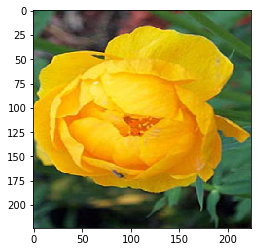

In [19]:
filepath = 'flowers/test/16/image_06657.jpg'
with Image.open(filepath) as img:
    np_img = process_image(img)
    imshow(np_img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [20]:
# DONE: Implement the code to predict the class from an image file
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        Arguments
        ---------
        image_path: string, path to the image file to process
        model: pytorch neural network, (trained) model used for inference
        topk: int, number of most likely classes to return
        
        Returns: 
        ---------
        probs: list of floats, the topk most likely class, as predicted by the model
        classes: list of strings, the most lilely classes attached to these probabilities
        
        /!\ Since the model returns indices, we want to do 
        idx -> classes -> class names, to return actual class names
    
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # choose the same device
    
    model.to(device) # move the model to device
    
    model.eval() # put model on eval mode
    
    # load image and transform to np array
    with Image.open(image_path) as img:
        np_img = process_image(img)
        
    # transform np array to FloatTensor
    tensor_img = torch.from_numpy(np_img).type(torch.FloatTensor)
    tensor_img = tensor_img.to(device) # move to device
    
    # reshape the float tensor
    tensor_img.unsqueeze_(0)
    
    with torch.no_grad():
        output = model.forward(tensor_img) # get the logits
        
    ps = torch.exp(output) # transform the logits into probabilities
    
    # get the top  𝐾  largest values
    probs, indices = ps.topk(topk)
    probs, indices = probs.to("cpu").numpy(), indices.to("cpu").numpy()
    
    # transform  indices -> class numbers
    #### print('class to idx {}.. '.format(model.classifier.class_to_idx))
    idx_to_class = {int(value):str(key) for key,value in model.classifier.class_to_idx.items()}
    #### print("idx to class {}.. ".format(idx_to_class))
    #### print('shape of indices : {}.. '.format(indices.shape))
    #### print('shape of probs[0] : {}.. '.format(probs[0].shape))
    classes = [idx_to_class[val] for val in indices[0]]
    #### print('probs: {}'.format(probs), 'indices: {}'.format(indices))
    #### print("predicted classes: {}.. ".format(classes))
    
    # return two lists with the probabilities and the class numbers
    return probs[0].tolist(), classes

In [21]:
def class_to_name(cat_number, cat_to_name):
    ''' Given class number and cat_to_name dictionary, returns class names
        Arguments
        ---------
        cat_number: list of values (in this context, strings), describing class numbers
        cat_to_name: dictionary that gives the cat_number -> cat_name correspondance
        
        Returns: 
        ---------
        class: list of string that is the corresponding class
    '''
    return [cat_to_name[cat] for cat in cat_number]

In [22]:
print(predict(filepath, model))
probs, cat_numbers = predict(filepath, model)
class_to_name(cat_numbers, cat_to_name)

([0.32953572273254395, 0.1486072689294815, 0.11946655064821243, 0.0817170962691307, 0.05374378338456154], ['16', '74', '96', '46', '11'])


['globe-flower', 'rose', 'camellia', 'wallflower', 'snapdragon']

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

<Container object of 5 artists>

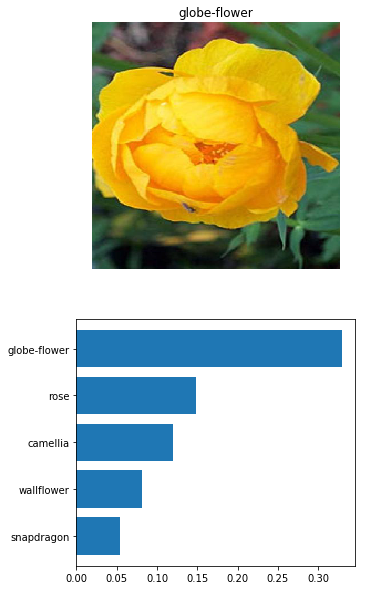

In [29]:
% matplotlib inline
# TODO: Display an image along with the top 5 classes
# load image
with Image.open(filepath) as img:
    np_img = process_image(img)
image_label = filepath.split("/")[2] # get image label, assuming is test
title = cat_to_name[image_label]

# get numbers
probs, cat_numbers = predict(filepath, model) # get probs
class_names = class_to_name(cat_numbers, cat_to_name) # get class names

plt.figure(figsize=(5, 10)) # create figure

# display picture
plt.subplot(2, 1, 1)
axs = imshow(np_img, ax = plt)
axs.axis('off')
axs.title(title)


# display probs and classes
# got some help from https://knowledge.udacity.com/questions/26067
plt.subplot(2, 1, 2)
y_pos = range(len(class_names))
plt.yticks(y_pos, reversed(class_names))
plt.barh(y_pos, list(reversed(probs)))